In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [2]:
tf.enable_eager_execution()

In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

### DATASETS

##### Loading Test Set

In [4]:
# Classifier and Adversarial Models tested on this set
X_test = []
y_test = []

dogPath = './PetImages/Test/Dog'

for p in os.listdir(dogPath):
    try:
        img_array = cv2.imread(os.path.join(dogPath, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X_test.append(new_img_array)
        y_test.append(1)
    except Exception as e:
        print(p)
        
catPath = './PetImages/Test/Cat'

for p in os.listdir(catPath):
    try:
        img_array = cv2.imread(os.path.join(catPath, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X_test.append(new_img_array)
        y_test.append(0)
    except Exception as e:
        print(p)

4367.jpg
6059.jpg
6238.jpg
6718.jpg
4833.jpg
5553.jpg


In [5]:
X_test = np.array(X_test, dtype='float32').reshape(-1, 80,80,1)
y_test = np.array(y_test, dtype='int64').reshape(-1, 1)
X_test = X_test/255.0

In [6]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([1840, 1796], dtype=int64))

##### Loading Train Set

In [14]:
# Adversarial Models trained on these images (sampled randomly from training set of classifier model)
X = []
y = []

dogPath = './PetImages/Train/Dog'

for p in np.random.choice(os.listdir(dogPath), size=1000):
    try:
        img_array = cv2.imread(os.path.join(dogPath, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(1)
    except Exception as e:
        print(p)
        
catPath = './PetImages/Train/Cat'

for p in np.random.choice(os.listdir(catPath), size=1000):
    try:
        img_array = cv2.imread(os.path.join(catPath, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(0)
    except Exception as e:
        print(p)

11410.jpg
3136.jpg
7969.jpg
7133.jpg
2663.jpg


In [15]:
X = np.array(X, dtype='float32').reshape(-1, 80,80,1)
y = np.array(y, dtype='int64').reshape(-1, 1)
X = X/255.0

In [16]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([999, 996], dtype=int64))

### CLASSIFIER MODELS

##### Neural Network

In [17]:
classifierModel = tf.keras.models.load_model('./Weights/dogCatClassifier.h5')

In [18]:
classifierModel.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
classifierModel.evaluate(X_test, y_test)

114/114 [==============================] - 2s 18ms/step


[0.35359093917347284, 0.8767876788334484]

### ADVERSARIAL MODELS

In [20]:
TRAIN_SIZE = X.shape[0]
TEST_SIZE = X_test.shape[0]
INPUT_SHAPE = 80
BATCH_SIZE = 10

# Adversarial Models trained on images sampled randomly from Train folder (1000 Cat, 1000 Dog)
dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X, tf.float32),
    tf.cast(y, tf.int64)))
dataset = dataset.shuffle(TRAIN_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Adversarial Models tested on images from Test folder (1840 Cat, 1796 Dog)
dataset_test = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_test, tf.float32),
    tf.cast(y_test, tf.int64)))
dataset_test = dataset_test.shuffle(TEST_SIZE).batch(BATCH_SIZE, drop_remainder=True)

##### NN with Cross Entropy (Goal Probs as 0.6/0.4)

In [27]:
modelHistory = {'reg_loss':[], 'miss_loss':[], 'values':[], 'noise':[], 'orig_labels':[], 'pred_labels':[], 'new_labels':[]}

adversarialModel = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE)/4, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE)/8, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE)/4, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE), activation=tf.nn.tanh)
])

In [30]:
REG_COEFF = 6.0
MIS_COEFF = 1.0
NUM_EPOCHS = 2

optimizer = tf.train.AdamOptimizer()

for epoch in range(NUM_EPOCHS):

    for (batch, (vals, orig_labels)) in enumerate(dataset.take(-1)):

        with tf.GradientTape() as tape:
            
            pred_labels = classifierModel(vals)
            noise = adversarialModel(vals)
            
            noise = tf.reshape(noise, shape=(BATCH_SIZE, INPUT_SHAPE, INPUT_SHAPE, 1))
            new_labels = classifierModel(tf.add(vals, noise))            
            
            regTerm = tf.math.multiply(tf.reduce_mean(tf.math.abs(noise)), REG_COEFF)
            missTerm = tf.math.multiply(tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
                tf.math.abs(tf.math.subtract(tf.to_float(pred_labels > 0.5), 0.6)), new_labels)), MIS_COEFF)

            loss = tf.add(regTerm, missTerm)

        grads = tape.gradient(loss, adversarialModel.trainable_variables)
        optimizer.apply_gradients(zip(grads, adversarialModel.trainable_variables), global_step=tf.train.get_or_create_global_step())

        if batch % 10 == 0:
            modelHistory['reg_loss'].append(regTerm.numpy())
            modelHistory['miss_loss'].append(missTerm.numpy())
            modelHistory['noise'].append(noise.numpy())
            modelHistory['values'].append(vals.numpy())
            modelHistory['orig_labels'].append(orig_labels.numpy())
            modelHistory['pred_labels'].append(pred_labels.numpy())
            modelHistory['new_labels'].append(new_labels.numpy())


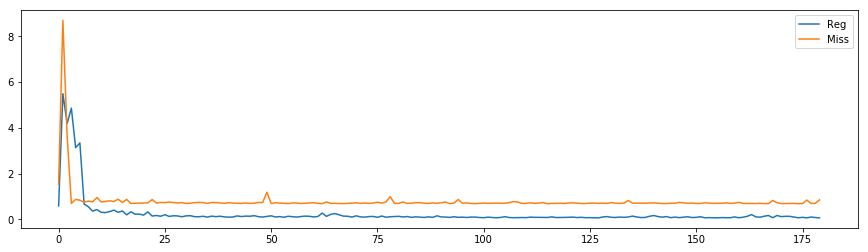

In [33]:
plt.figure(figsize=(15,4))
plt.plot(modelHistory['reg_loss'])
plt.plot(modelHistory['miss_loss'])
plt.legend(['Reg', 'Miss'])
# plt.savefig('./Plots/NN with CE [Goal 60+40]/P2.png')

In [49]:
# adversarialModel.save_weights('./dogCatAdversarialWeights')

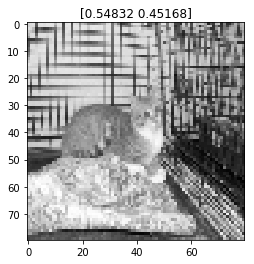

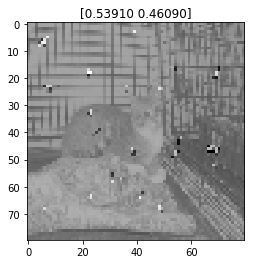

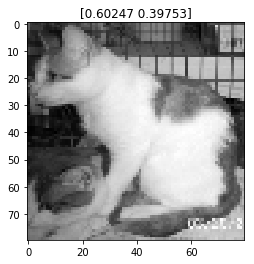

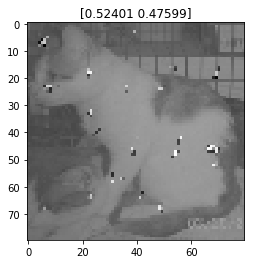

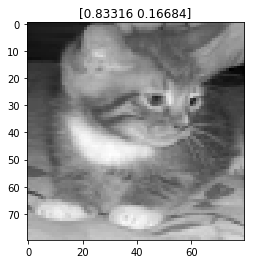

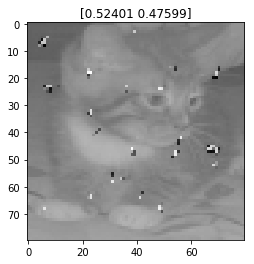

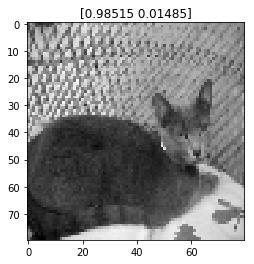

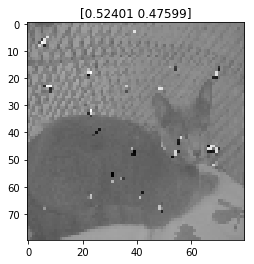

In [34]:
for val, lab in dataset_test.take(1):
    
    noise = adversarialModel(val)    
    noise = tf.reshape(noise, shape=(10, 80, 80, 1))
    
    final = noise + val
    pred_labels = classifierModel(val)
    new_labels = classifierModel(final)
    
    for i in range(4):
        plt.imshow(val[i].numpy().reshape(80, 80), cmap="gray")
        plt.title(pred_labels.numpy()[i])
#         plt.savefig('./Plots/NN with CE [Goal 60+40]/D2_' + str(i) + '_C.png')
        plt.show()
        plt.title(new_labels.numpy()[i])
        plt.imshow(final[i].numpy().reshape(80, 80), cmap="gray")
#         plt.savefig('./Plots/NN with CE [Goal 60+40]/D2_' + str(i) + '_M.png')
        plt.show()


In [35]:
abs(modelHistory['noise'][-1]).mean()

0.011011404

In [36]:
for i in range(10):
    print((modelHistory['values'][-i] + modelHistory['noise'][-i]).mean())

0.43399766
0.51983315
0.4376773
0.5179366
0.48534167
0.43143818
0.38677436
0.41927585
0.4077187
0.39535588


Goal Probs = 0.6/0.4
Epochs = 6
REG_COEFF = 6.0
MIS_COEFF = 1.0
Train Set Size = 1000 + 1000
Always produces [0.52401 0.47599] for both cat and dog samples
Tries to reach same goal state (adds greyish tinge to all pixels except some, which become same for all images)

##### NN with Cross Entropy (Goal Probs as 1/0)

In [24]:
modelHistory = {'reg_loss':[], 'miss_loss':[], 'values':[], 'noise':[], 'orig_labels':[], 'pred_labels':[], 'new_labels':[]}

adversarialModel = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE)/4, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE)/8, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE)/4, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense((INPUT_SHAPE * INPUT_SHAPE), activation=tf.nn.tanh)
])

In [27]:
REG_COEFF = 10.0
MIS_COEFF = 1.0
NUM_EPOCHS = 5

optimizer = tf.train.AdamOptimizer()

for epoch in range(NUM_EPOCHS):

    for (batch, (vals, orig_labels)) in enumerate(dataset.take(-1)):

        with tf.GradientTape() as tape:
            
            pred_labels = classifierModel(vals)
            noise = adversarialModel(vals)
            
            noise = tf.reshape(noise, shape=(BATCH_SIZE, INPUT_SHAPE, INPUT_SHAPE, 1))
            new_labels = classifierModel(tf.add(vals, noise))            
            
            regTerm = tf.math.multiply(tf.reduce_mean(tf.math.abs(noise)), REG_COEFF)
            missTerm = tf.math.multiply(tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
                tf.math.subtract(1, tf.math.argmax(pred_labels, axis=1)), new_labels)), MIS_COEFF)

            loss = tf.add(regTerm, missTerm)

        grads = tape.gradient(loss, adversarialModel.trainable_variables)
        optimizer.apply_gradients(zip(grads, adversarialModel.trainable_variables), global_step=tf.train.get_or_create_global_step())

        if batch % 10 == 0:
            modelHistory['reg_loss'].append(regTerm.numpy())
            modelHistory['miss_loss'].append(missTerm.numpy())
            modelHistory['noise'].append(noise.numpy())
            modelHistory['values'].append(vals.numpy())
            modelHistory['orig_labels'].append(orig_labels.numpy())
            modelHistory['pred_labels'].append(pred_labels.numpy())
            modelHistory['new_labels'].append(new_labels.numpy())


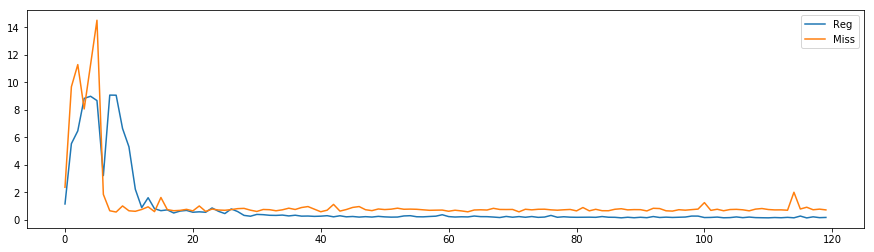

In [30]:
plt.figure(figsize=(15,4))
plt.plot(modelHistory['reg_loss'])
plt.plot(modelHistory['miss_loss'])
plt.legend(['Reg', 'Miss'])
plt.savefig('./Plots/NN with CE [Goal 100+0]/P1.png')

In [49]:
# adversarialModel.save_weights('./dogCatAdversarialWeights')

c:\users\shivin\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


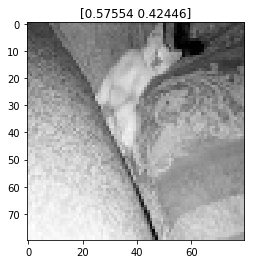

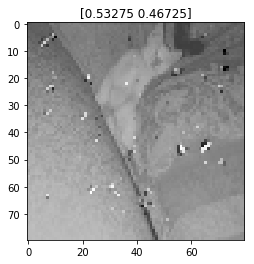

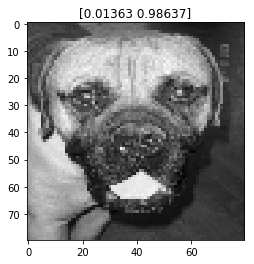

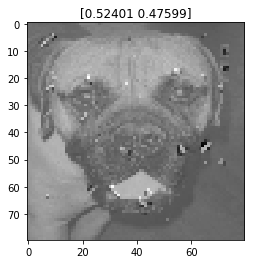

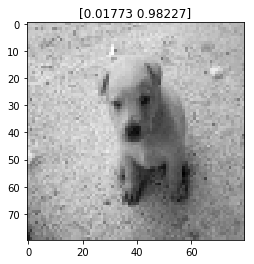

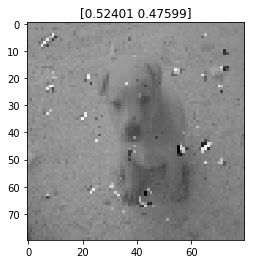

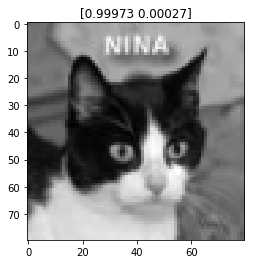

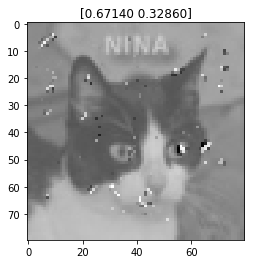

In [31]:
for val, lab in dataset_test.take(1):
    
    noise = adversarialModel(val)    
    noise = tf.reshape(noise, shape=(10, 80, 80, 1))
    
    final = noise + val
    pred_labels = classifierModel(val)
    new_labels = classifierModel(final)
    
    for i in range(4):
        plt.imshow(val[i].numpy().reshape(80, 80), cmap="gray")
        plt.title(pred_labels.numpy()[i])
        plt.savefig('./Plots/NN with CE [Goal 100+0]/D1_' + str(i) + '_C.png')
        plt.show()
        plt.title(new_labels.numpy()[i])
        plt.imshow(final[i].numpy().reshape(80, 80), cmap="gray")
        plt.savefig('./Plots/NN with CE [Goal 100+0]/D1_' + str(i) + '_M.png')
        plt.show()


In [32]:
abs(modelHistory['noise'][-1]).mean()

0.017590137

In [33]:
for i in range(10):
    print((modelHistory['values'][-i] + modelHistory['noise'][-i]).mean())

0.5041682
0.50133276
0.47399706
0.48326275
0.4038235
0.5323792
0.49796644
0.46925694
0.47663397
0.47235772


Goal Probs = 0.6/0.4
Epochs = 6
REG_COEFF = 6.0
MIS_COEFF = 1.0
Train Set Size = 1000 + 1000
Always produces [0.52401 0.47599] for both cat and dog samples
Tries to reach same goal state (adds greyish tinge to all pixels except some, which become same for all images)

##### Temp Calculations

In [42]:
pred_temp = tf.constant([[0.01147, 0.98853],
         [0.00000, 1.00000],
         [0.99151, 0.00849],
         [0.26106, 0.73894],
         [0.50131, 0.49869],
         [0.99630, 0.00370],
         [0.44431, 0.55569],
         [0.42876, 0.57124],
         [0.22989, 0.77011],
         [0.00000, 1.00000]])
new_temp = tf.constant([[0.00954, 0.99046],
         [0.00000, 1.00000],
         [0.99190, 0.00810],
         [0.23041, 0.76959],
         [0.81404, 0.18596],
         [0.99646, 0.00354],
         [0.42733, 0.57267],
         [0.41239, 0.58761],
         [0.21904, 0.78096],
         [0.00000, 1.00000]])
miss_loss = 5.375216

In [43]:
tf.math.abs(tf.math.subtract(tf.to_float(pred_temp > 0.5), 0.6))

<tf.Tensor: id=2544243, shape=(10, 2), dtype=float32, numpy=
array([[0.60000, 0.40000],
       [0.60000, 0.40000],
       [0.40000, 0.60000],
       [0.60000, 0.40000],
       [0.40000, 0.60000],
       [0.40000, 0.60000],
       [0.60000, 0.40000],
       [0.60000, 0.40000],
       [0.60000, 0.40000],
       [0.60000, 0.40000]], dtype=float32)>

In [44]:
tf.keras.losses.categorical_crossentropy(tf.math.abs(tf.math.subtract(tf.to_float(pred_temp > 0.5), 0.6)), new_temp)

<tf.Tensor: id=2544263, shape=(10,), dtype=float32, numpy=
array([2.79519, 9.67086, 2.89279, 0.98550, 1.09163, 3.38760, 0.73310,
       0.74415, 1.00999, 9.67086], dtype=float32)>

##### NN with MSE

In [181]:
REG_COEFF = 10.0
MIS_COEFF = 1.0
BATCH_SIZE = 10
NUM_EPOCHS = 10
modelHistory = {'reg_loss':[], 'miss_loss':[], 'values':[], 'noise':[], 'orig_labels':[], 'pred_labels':[], 'new_labels':[]}


adversarialModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.tanh)
])

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(np.reshape(train_data['Value'].values, newshape=(-1,1)), tf.float32),
    tf.cast(np.reshape(train_data['Label'].values, newshape=(-1,1)), tf.int64)))

dataset = dataset.batch(BATCH_SIZE)

In [182]:
optimizer = tf.train.AdamOptimizer()

for epoch in range(NUM_EPOCHS):

    for (batch, (vals, orig_labels)) in enumerate(dataset.take(-1)):
        
        with tf.GradientTape() as tape:
            
            pred_labels = classifierModel(vals)
            noise = adversarialModel(vals)
            new_labels = classifierModel(tf.add(vals, noise))

            regTerm = tf.math.multiply(tf.reduce_mean(tf.math.abs(noise)), REG_COEFF)
            missTerm = tf.math.multiply(tf.reduce_mean(tf.cast(tf.math.abs(
                        tf.math.subtract(tf.argmax(new_labels, axis=1), 
                                         tf.math.subtract(1, tf.argmax(pred_labels, axis=1)))), dtype=tf.float32)), MIS_COEFF)

            loss = tf.add(0.0, missTerm)

        grads = tape.gradient(loss, adversarialModel.trainable_variables)
        optimizer.apply_gradients(zip(grads, adversarialModel.trainable_variables), global_step=tf.train.get_or_create_global_step())
        
        if batch%10 == 0:
            modelHistory['reg_loss'].append(regTerm.numpy())
            modelHistory['miss_loss'].append(missTerm.numpy())
            modelHistory['noise'].append(noise.numpy())
            modelHistory['values'].append(vals.numpy())
            modelHistory['orig_labels'].append(orig_labels.numpy())
            modelHistory['pred_labels'].append(pred_labels.numpy())
            modelHistory['new_labels'].append(new_labels.numpy())
    

ValueError: No gradients provided for any variable: ["<tf.Variable 'sequential_27/dense_56/kernel:0' shape=(1, 32) dtype=float32, numpy=\narray([[0.40769, -0.42173, 0.17348, 0.39773, -0.23833, 0.03840, -0.34746,\n        0.34388, 0.34044, 0.23163, -0.16805, 0.10308, -0.01149, 0.02108,\n        0.36514, -0.10401, 0.31591, -0.05579, -0.38195, 0.28266, 0.14739,\n        -0.33268, 0.07754, 0.14226, 0.16608, 0.15056, -0.31268, 0.31612,\n        -0.00803, 0.00937, 0.39809, -0.42474]], dtype=float32)>", "<tf.Variable 'sequential_27/dense_56/bias:0' shape=(32,) dtype=float32, numpy=\narray([0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,\n       0.00000, 0.00000, 0.00000, 0.00000], dtype=float32)>", "<tf.Variable 'sequential_27/dense_57/kernel:0' shape=(32, 1) dtype=float32, numpy=\narray([[-0.29608],\n       [0.12203],\n       [-0.08916],\n       [0.06394],\n       [0.37802],\n       [-0.26736],\n       [-0.01670],\n       [0.03174],\n       [-0.27751],\n       [-0.33127],\n       [-0.11258],\n       [-0.23834],\n       [-0.40621],\n       [0.12249],\n       [-0.34884],\n       [0.02532],\n       [-0.20805],\n       [-0.22921],\n       [-0.37431],\n       [-0.39454],\n       [0.10150],\n       [0.15959],\n       [0.32745],\n       [-0.39941],\n       [-0.31263],\n       [-0.40050],\n       [0.05922],\n       [-0.26880],\n       [-0.21995],\n       [0.41699],\n       [0.27475],\n       [-0.31295]], dtype=float32)>", "<tf.Variable 'sequential_27/dense_57/bias:0' shape=(1,) dtype=float32, numpy=array([0.00000], dtype=float32)>"].

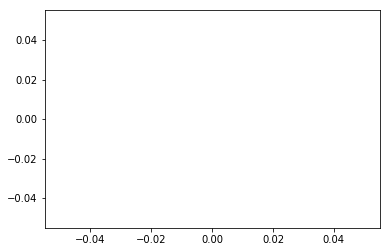

In [183]:
plt.plot(modelHistory['reg_loss'])
plt.plot(modelHistory['miss_loss'])

In [162]:
tf.argmax(modelHistory['pred_labels'][-1], axis=1)

<tf.Tensor: id=42075962, shape=(10,), dtype=int64, numpy=array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int64)>

In [163]:
tf.argmax(modelHistory['new_labels'][-1], axis=1)

<tf.Tensor: id=42075966, shape=(10,), dtype=int64, numpy=array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int64)>

In [180]:
modelHistory['noise'][-1]

array([[0.00024],
       [0.00045],
       [0.00072],
       [0.00084],
       [0.00063],
       [0.00181],
       [-0.00011],
       [0.00038],
       [0.00085],
       [0.00047]], dtype=float32)

In [165]:
modelHistory['values'][-1]

array([[4.44658],
       [4.97225],
       [5.97969],
       [6.46982],
       [5.59160],
       [9.38508],
       [1.18535],
       [4.77804],
       [6.52005],
       [5.05724]], dtype=float32)

In [166]:
modelHistory['pred_labels'][-1]

array([[0.07628, 0.92372],
       [0.71141, 0.28859],
       [0.25155, 0.74845],
       [0.24900, 0.75100],
       [0.89552, 0.10448],
       [0.58070, 0.41930],
       [0.99686, 0.00314],
       [0.10741, 0.89259],
       [0.26053, 0.73947],
       [0.91246, 0.08754]], dtype=float32)

In [167]:
modelHistory['new_labels'][-1]

array([[0.95502, 0.04498],
       [0.58634, 0.41366],
       [0.28208, 0.71792],
       [0.36203, 0.63797],
       [0.22677, 0.77323],
       [0.54220, 0.45780],
       [0.00997, 0.99003],
       [0.84883, 0.15117],
       [0.36634, 0.63366],
       [0.40068, 0.59932]], dtype=float32)

##### Decision Tree with MSE

In [33]:
REG_COEFF = 1.0
MIS_COEFF = 5.0
BATCH_SIZE = 10
NUM_EPOCHS = 1
modelHistory = {'reg_loss':[], 'miss_loss':[], 'values':[], 'noise':[], 'orig_labels':[], 'pred_labels':[], 'new_labels':[]}


adversarialModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.tanh)
])

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(np.reshape(train_data['Value'].values, newshape=(-1,1)), tf.float32),
    tf.cast(np.reshape(train_data['Label'].values, newshape=(-1,1)), tf.int64)))

dataset = dataset.batch(BATCH_SIZE)

In [34]:
optimizer = tf.train.AdamOptimizer()

for epoch in range(NUM_EPOCHS):

    for (batch, (vals, orig_labels)) in enumerate(dataset.take(-1)):
        
        with tf.GradientTape() as tape:
            
            pred_labels = myTree.predict(vals.numpy())
            noise = adversarialModel(vals)
            new_labels = myTree.predict(tf.add(vals, noise).numpy())

            regTerm = tf.reduce_mean(tf.math.square(noise))
            missTerm = tf.reduce_mean(tf.cast(tf.math.abs(
                        tf.math.subtract(new_labels, tf.math.subtract(1, pred_labels))), dtype=tf.float32))

            loss = missTerm
            #tf.add(tf.math.multiply(0.0, REG_COEFF), tf.math.multiply(missTerm, MIS_COEFF))

        grads = tape.gradient(loss, adversarialModel.trainable_variables)
        optimizer.apply_gradients(zip(grads, adversarialModel.trainable_variables), global_step=tf.train.get_or_create_global_step())
        
        if batch%10 == 0:
            modelHistory['reg_loss'].append(regTerm.numpy())
            modelHistory['miss_loss'].append(missTerm.numpy())
            modelHistory['noise'].append(noise.numpy())
            modelHistory['values'].append(vals.numpy())
            modelHistory['orig_labels'].append(orig_labels.numpy())
            modelHistory['pred_labels'].append(pred_labels)
            modelHistory['new_labels'].append(new_labels)
    

ValueError: No gradients provided for any variable: ["<tf.Variable 'sequential_3/dense_6/kernel:0' shape=(1, 32) dtype=float32, numpy=\narray([[ 2.88196266e-01,  3.85440886e-01,  4.61042225e-02,\n         3.13634157e-01, -2.14485824e-01,  2.37595558e-01,\n         3.65222454e-01,  2.92484403e-01,  4.05001998e-01,\n         2.87741423e-01,  4.15382981e-01,  1.40994787e-04,\n        -5.53731620e-02,  4.25974369e-01,  2.95409918e-01,\n        -4.09557372e-01, -2.68551618e-01, -6.13611937e-03,\n        -4.68383431e-02,  1.44419253e-01, -3.01740319e-01,\n        -2.23388776e-01, -3.33287954e-01,  2.30480134e-01,\n         3.58040512e-01,  2.95596182e-01,  1.00669205e-01,\n         2.77746022e-01,  1.24676466e-01,  3.33411694e-01,\n        -1.15648687e-01,  1.37585700e-01]], dtype=float32)>", "<tf.Variable 'sequential_3/dense_6/bias:0' shape=(32,) dtype=float32, numpy=\narray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],\n      dtype=float32)>", "<tf.Variable 'sequential_3/dense_7/kernel:0' shape=(32, 1) dtype=float32, numpy=\narray([[-0.25014216],\n       [-0.02677321],\n       [-0.16590044],\n       [ 0.01334751],\n       [ 0.11586785],\n       [ 0.21186316],\n       [ 0.29636788],\n       [ 0.0011687 ],\n       [ 0.15724003],\n       [-0.41779187],\n       [-0.03569192],\n       [-0.37300092],\n       [-0.09307066],\n       [ 0.0190351 ],\n       [-0.17378554],\n       [ 0.15034372],\n       [-0.1028659 ],\n       [-0.29841077],\n       [-0.23481406],\n       [-0.3392158 ],\n       [ 0.13119495],\n       [ 0.36371744],\n       [ 0.3285126 ],\n       [-0.18267354],\n       [-0.37584704],\n       [-0.40394533],\n       [ 0.03710786],\n       [-0.2671455 ],\n       [ 0.07168719],\n       [ 0.29223043],\n       [ 0.39716595],\n       [ 0.2776329 ]], dtype=float32)>", "<tf.Variable 'sequential_3/dense_7/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>"].

In [ ]:
plt.plot(modelHistory['reg_loss'])
plt.plot(modelHistory['miss_loss'])

##### Graphs and Sessions

In [16]:
BATCH_SIZE = 10


def lossFunc(noise, orig_label, value_input):
    
    new_labels = classifierModel.predict(tf.add(noise, value_input), steps=1)
    
    regTerm = tf.reduce_mean(tf.math.square(noise))
    # Comparing accuracy of produced
    missTerm = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(tf.math.subtract(1, orig_label), 
                                                                              new_labels))
    
    # tf.reduce_mean(tf.math.squared_difference(tf.cast(tf.math.subtract(1, orig_label), dtype=tf.int32), 
    #                                                   tf.cast(tf.argmax(newLabel, axis=1), dtype=tf.int32)))
    
    return (tf.math.multiply(regTerm, REG_COEFF), tf.math.multiply(missTerm, MIS_COEFF), new_labels)


def noiseModel(inputs):
    l1 = tf.contrib.layers.flatten(inputs)
    l2 = tf.contrib.layers.fully_connected(l1, 32, activation_fn = tf.nn.tanh)
    l3 = tf.contrib.layers.dropout(l2, keep_prob=0.5)
    l4 = tf.contrib.layers.fully_connected(l3, 1, activation_fn = tf.nn.tanh)
    return l4

value_input = tf.placeholder(tf.float32, shape = (BATCH_SIZE, 1))
orig_label = tf.placeholder(tf.int32, shape = (BATCH_SIZE, 1))

noise = noiseModel(value_input)

regTerm, missTerm, new_labels = lossFunc(noise, orig_label, value_input)
loss = missTerm
# tf.math.add(regTerm, missTerm)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

accuracy = tf.reduce_mean(tf.metrics.accuracy(tf.math.subtract(1, orig_label), tf.argmax(new_labels, axis=1)))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [10,1]
	 [[{{node Placeholder}} = Placeholder[dtype=DT_FLOAT, shape=[10,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node Softmax/_139}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_89_Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
modelHistory = {'regLoss':[], 'missLoss':[], 'totalLoss':[], 'noise':[], 'batchValues':[], 'batchLabels':[], 'newLabels':[]}

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    classifierModel.load_weights('./classifierNNWeights')
    # Training noise on batches of train_data
    
    for epochNum in range(1000):
        
        trainValuesBatches = np.array_split(train_data['Value'].values, int(TRAIN_EXAMPLES/BATCH_SIZE))
        trainLabelsBatches = np.array_split(train_data['Label'].values, int(TRAIN_EXAMPLES/BATCH_SIZE))
        
        for batchNum in np.random.randint(high=int(TRAIN_EXAMPLES/BATCH_SIZE)-1, low=0, size=(BATCH_SIZE, )):
            
            singleBatchValues = np.reshape(trainValuesBatches[batchNum], newshape=(-1,1))
            singleBatchLabels = np.reshape(trainLabelsBatches[batchNum], newshape=(-1,1))
            
            #noise_val = sess.run([noise], feed_dict={value_input : singleBatchValues})
            
            #new_labels_val = classifierModel.predict(trainValuesBatches[batchNum] + np.reshape(noise_val, newshape=(10, )))
            
            # if epochNum == 999:
#             print("ORIG VALUES : ")
#             print(trainValuesBatches[batchNum])
#             print("ORIG LABELS : ")
#             print(classifierModel.predict(trainValuesBatches[batchNum]))
#             print("NOISE : ")
#             print(noise_val)
#             print("NEW LABELS : ")
#             print(new_labels_val)
            
            _, reg_val, miss_val, noise_val, new_labels_val = sess.run([optimizer, regTerm, missTerm, noise, new_labels], 
                                                             feed_dict={value_input : singleBatchValues,
                                                                        orig_label : singleBatchLabels})
            
    
    
    # Testing noise on batches of test_data
    
#     testValuesBatches = np.array_split(test_data['Value'].values, int(TEST_EXAMPLES/BATCH_SIZE))
#     testLabelsBatches = np.array_split(test_data['Label'].values, int(TEST_EXAMPLES/BATCH_SIZE))
    
#     accuHistory = []
    
#     for batchNum in range(int(TEST_EXAMPLES/BATCH_SIZE)):
        
#         acc_val = sess.run([accuracy], feed_dict={value_input : np.reshape(testValuesBatches[batchNum], newshape=(-1,1)),
#                                                    orig_label : np.reshape(testLabelsBatches[batchNum], newshape=(-1,1))})
        
#         accuHistory.append(acc_val)
        

In [ ]:
plt.plot(modelHistory['regLoss'])
plt.plot(modelHistory['missLoss'])
# plt.plot(modelHistory['totalLoss'])

In [ ]:
modelHistory['batchValues'][-1]

In [ ]:
classifierModel.predict(modelHistory['batchValues'][-1])

In [ ]:
modelHistory['noise'][-1][0].reshape(10,)

In [ ]:
modelHistory['batchValues'][-1] + modelHistory['noise'][-1][0].reshape(10,)

In [ ]:
np.argmax(modelHistory['newLabels'][-1], axis=1)

In [ ]:
np.argmax(classifierModel.predict(modelHistory['batchValues'][-1] + modelHistory['noise'][-1][0].reshape(10,)), axis=1)